### Data

In [1]:
%cd SOICTHackathon2024

[Errno 2] No such file or directory: 'SOICTHackathon2024'
/home/quangminh/Documents/code/Python/SOICTHackathon2024


In [2]:
import os 

In [5]:
train_folder = 'datasets/grayscale_train/train'
val_folder = 'datasets/grayscale_train/validation'

In [6]:
train_img_list = os.listdir(train_folder + '/images')

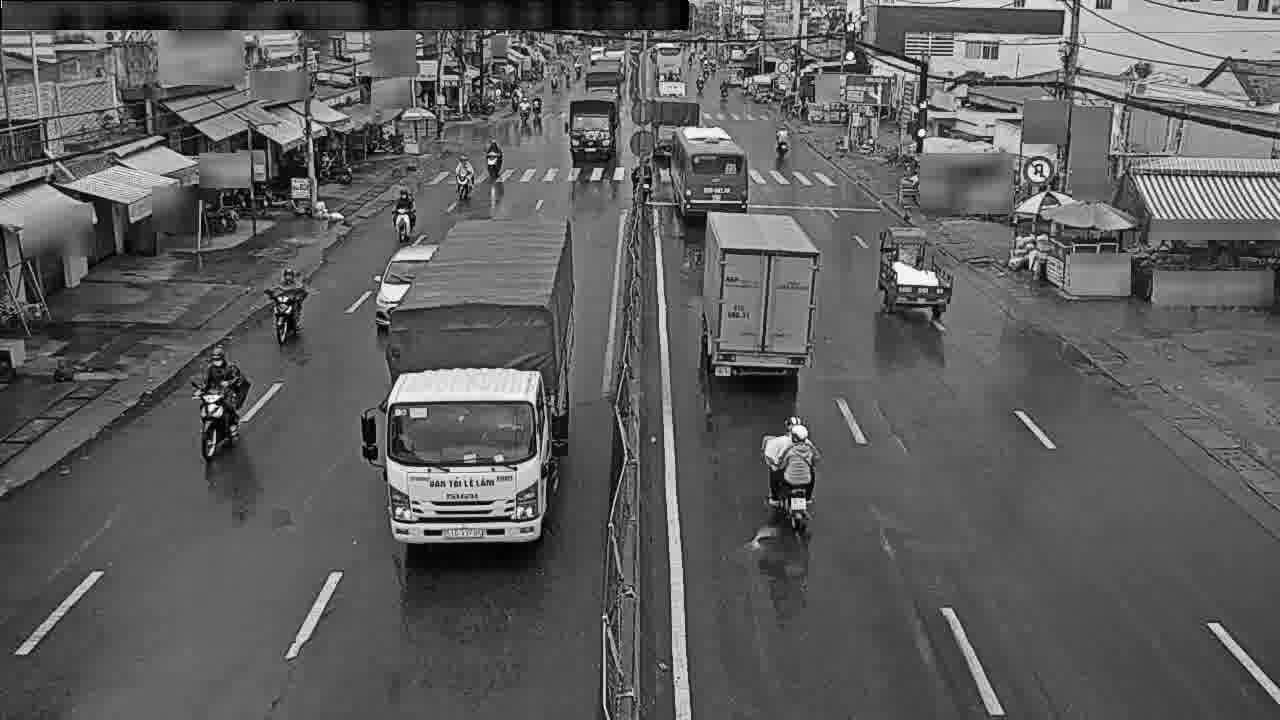

In [7]:
from PIL import Image
from IPython.display import display

im = Image.open(train_folder + '/images/' + train_img_list[25])
width, height = im.size
display(im)

In [8]:
print(width, height)

1280 720


In [ ]:
# !pip install albumentations

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import cv2
import torch


class CustomDataset(Dataset):
    def __init__(self, images_dir, labels_dir, img_size=640, mode='train'):
        """
        Custom dataset for YOLO.

        Args:
            images_dir (str): Directory with images.
            labels_dir (str): Directory with label files.
            img_size (int): Target image size (YOLO often expects square images).
            transform (callable, optional): Optional transform to apply to images.
        """

        self.img_size = img_size
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        if mode == 'train':
            self.transform = A.Compose([
                A.RandomCrop(width=640, height=640),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()  # Convert to PyTorch tensor
            ])

        else:
            self.transform = A.Compose([
                A.Resize(width=640, height=640),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()  # Convert to PyTorch tensor
            ])
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]
        

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Resize image to target size
        image = cv2.resize(image, (self.img_size, self.img_size))
        
        # Load label
        label_path = os.path.join(self.labels_dir, self.label_files[idx])

        # Convert image to tensor and normalize
        image = torch.from_numpy(image).float() / 255.0  # Normalize to [0,1]
        image = image.permute(2, 0, 1)  # Change to (C, H, W) format for PyTorch

        # Apply any data transformations
        if self.transform:
            image = self.transform(image)
        
        boxes = []
        with open(label_path, 'r') as f:
            for line in f.readlines():
                label = line.strip().split()
                # YOLO labels: [class, x_center, y_center, width, height]
                class_id = int(label[0])
                x_center, y_center, width, height = map(float, label[1:])
                boxes.append([class_id, x_center, y_center, width, height])

        return image, boxes


### Model

In [ ]:
%pip install -U ultralytics

Note: you may need to restart the kernel to use updated packages.


In [46]:
from ultralytics import YOLO, settings, RTDETR

In [11]:
print(settings)

JSONDict("/home/quangminh/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets",
  "weights_dir": "weights",
  "runs_dir": "runs",
  "uuid": "288e0b2b0a213dec20ec52bec1e49eb19387b36ea96f2042338a72c0bcf1dedf",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": false,
  "wandb": true,
  "vscode_msg": true
}


In [12]:
# Update multiple settings
settings.update({"datasets_dir": "/home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets", 
                 "tensorboard": False})

In [13]:
import os 
os.environ['WANDB_API_KEY'] = '0914f403b30196f64eb9744f9310b0029205c241'

In [14]:
# Load a model
model = YOLO("yolo11n.pt")  # model name

# Display model information (optional)
model.info()

# Train the model
train_results = model.train(
    data="/home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/grayscale_traindata.yaml",  # path to dataset YAML
    epochs=20,  # number of training epochs
    imgsz=640,  # training image size
    device="cuda",  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
    batch=16,  # batch size
    workers=8,  # number of 
    dropout=0.1,  # dropout ratio,
    save_period=5,  # save model every 10 epochs,
    # name = 'train',  # name of the run
    # resume = "path/to/last.pt", # resume training from a model with a checkpoint file,
    augment = True,  # use data augmentation during training,
    iou = 1.0,
    seed = 42 # random seed
)


# # Evaluate model performance on the validation set
# metrics = model.val()

# Export the model to ONNX format
path = model.export(format="onnx")  # return path to exported model  

YOLO11n summary: 319 layers, 2,624,080 parameters, 0 gradients, 6.6 GFLOPs
New https://pypi.org/project/ultralytics/8.3.29 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.28 🚀 Python-3.12.0 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/grayscale_traindata.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=5, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.1, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=1.0, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: daoxuanquangminh2004 (daoxuanquangminh2004-hanoi-university-of-science-and-tec). Use `wandb login --relogin` to force relogin


Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅


train: Scanning /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/grayscale_train/train/labels.cache... 9335 images, 1033 backgrounds, 0 corrupt: 100%|██████████| 10368/10368 [00:00<?, ?it/s]

train: WARNING ⚠️ /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/grayscale_train/train/images/cam_01_00317.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/grayscale_train/train/images/cam_01_00857.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/grayscale_train/train/images/cam_01_00961.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/grayscale_train/train/images/cam_02_00316.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/grayscale_train/train/images/cam_02_00951.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/grayscale_train/train/images/cam_04_00014.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /home/quangminh/Documents/code/Pyt


val: Scanning /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/grayscale_train/validation/labels.cache... 121 images, 1032 backgrounds, 0 corrupt: 100%|██████████| 1153/1153 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.89G      1.525       1.65      1.061        326        640: 100%|██████████| 648/648 [02:31<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:07<00:00,  4.74it/s]


                   all       1153       1288     0.0558      0.247     0.0408     0.0297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      3.47G      1.383      1.026      1.011        448        640: 100%|██████████| 648/648 [02:21<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:04<00:00,  7.57it/s]


                   all       1153       1288     0.0544      0.209     0.0401     0.0285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      3.74G      1.331     0.9242     0.9975        147        640: 100%|██████████| 648/648 [02:19<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:05<00:00,  6.92it/s]


                   all       1153       1288     0.0571      0.224     0.0371     0.0266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.99G      1.301     0.8615     0.9867        314        640: 100%|██████████| 648/648 [02:21<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:05<00:00,  6.92it/s]


                   all       1153       1288     0.0548      0.148     0.0383     0.0295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.78G      1.275     0.8348     0.9791        398        640: 100%|██████████| 648/648 [02:24<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:05<00:00,  7.21it/s]


                   all       1153       1288     0.0393      0.183     0.0315     0.0249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      3.66G      1.249     0.8059     0.9729        296        640: 100%|██████████| 648/648 [02:21<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:04<00:00,  7.45it/s]


                   all       1153       1288     0.0384      0.189     0.0279     0.0226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      3.61G      1.235     0.7844     0.9682        290        640: 100%|██████████| 648/648 [02:19<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:05<00:00,  7.17it/s]


                   all       1153       1288     0.0311      0.182     0.0259     0.0209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.51G      1.214     0.7713     0.9629        346        640: 100%|██████████| 648/648 [02:19<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:05<00:00,  7.36it/s]


                   all       1153       1288     0.0509      0.162     0.0332     0.0268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.52G      1.201     0.7587     0.9578        243        640: 100%|██████████| 648/648 [02:20<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:04<00:00,  7.42it/s]


                   all       1153       1288     0.0347      0.256     0.0309     0.0252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      3.79G      1.182     0.7444     0.9528        257        640: 100%|██████████| 648/648 [02:20<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:04<00:00,  7.41it/s]


                   all       1153       1288     0.0315      0.198     0.0263     0.0212
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       3.4G      1.178     0.7277     0.9562        181        640: 100%|██████████| 648/648 [02:16<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:05<00:00,  7.37it/s]


                   all       1153       1288     0.0415      0.178      0.029     0.0235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.93G      1.163     0.7182     0.9527        197        640: 100%|██████████| 648/648 [02:15<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:05<00:00,  7.24it/s]


                   all       1153       1288     0.0424       0.19      0.034     0.0287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.05G      1.147      0.704     0.9466        170        640: 100%|██████████| 648/648 [02:16<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:05<00:00,  7.28it/s]


                   all       1153       1288     0.0269      0.194     0.0266      0.022

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      3.29G      1.136     0.6937     0.9437        132        640: 100%|██████████| 648/648 [02:16<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:05<00:00,  7.28it/s]


                   all       1153       1288     0.0318      0.159     0.0308     0.0262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.96G      1.127     0.6817     0.9414        158        640: 100%|██████████| 648/648 [02:16<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:05<00:00,  7.06it/s]


                   all       1153       1288      0.027      0.138     0.0262     0.0219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.96G      1.108     0.6706     0.9369        129        640: 100%|██████████| 648/648 [02:15<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:05<00:00,  7.22it/s]


                   all       1153       1288       0.03      0.144      0.029      0.025

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.73G        1.1     0.6669     0.9331        142        640: 100%|██████████| 648/648 [02:15<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:05<00:00,  7.35it/s]


                   all       1153       1288     0.0231      0.195     0.0215     0.0178

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      3.07G      1.092     0.6544     0.9327         87        640: 100%|██████████| 648/648 [02:15<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:05<00:00,  7.27it/s]


                   all       1153       1288     0.0265      0.207     0.0252     0.0213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      3.02G      1.078     0.6481     0.9281        106        640: 100%|██████████| 648/648 [02:16<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:05<00:00,  6.82it/s]


                   all       1153       1288     0.0292      0.161     0.0306     0.0266

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      3.24G      1.071     0.6404     0.9255        225        640: 100%|██████████| 648/648 [02:20<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:05<00:00,  7.22it/s]


                   all       1153       1288     0.0319      0.154     0.0299     0.0258

20 epochs completed in 0.810 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.28 🚀 Python-3.12.0 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
YOLO11n summary (fused): 238 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 37/37 [00:22<00:00,  1.68it/s]


                   all       1153       1288     0.0507      0.258     0.0345     0.0256
             motorbike        108        776     0.0591     0.0515       0.02     0.0127
                   car         80        272      0.043      0.298     0.0373     0.0265
                   van         47         69     0.0172      0.478     0.0385     0.0322
                 truck         74        171     0.0837      0.205     0.0423     0.0311
Speed: 0.2ms preprocess, 5.7ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs/detect/train


lr/pg0,▃▆██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
lr/pg1,▃▆██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
lr/pg2,▃▆██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
metrics/mAP50(B),██▇▇▅▃▃▅▄▃▄▆▃▄▃▄▁▂▄▆
metrics/mAP50-95(B),█▇▆█▅▄▃▆▅▃▄▇▃▆▃▅▁▃▆▆
metrics/precision(B),█▇██▄▄▃▇▃▃▅▅▂▃▂▂▁▂▂▇
metrics/recall(B),▇▅▆▂▄▄▄▂█▅▃▄▄▂▁▁▄▅▂█
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁


Ultralytics 8.3.28 🚀 Python-3.12.0 torch-2.5.0+cu124 CPU (12th Gen Intel Core(TM) i5-12500H)
YOLO11n summary (fused): 238 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (5.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 2.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 4.0 MB/s eta 0:00:0000:0100:02

requirements: AutoUpdate success ✅ 97.1s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.39...
ONNX: export success ✅ 99.4s, saved as 'runs/detect/train/weights/best.onnx' (10.1 MB)

Export comple

### test

In [3]:
!unzip /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/public_test.zip -d /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets

Archive:  /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/public_test.zip
   creating: /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/public test/
  inflating: /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/public test/cam_08_00500_jpg.rf.5151346676b87b9d97d375b50e60a9b8.jpg  
  inflating: /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/public test/cam_08_00500_jpg.rf.5ab59b5bcda1d1fad9131385c5d64fdb.jpg  
  inflating: /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/public test/cam_08_00501_jpg.rf.76f1baf9183c5809797b116f4d6286f8.jpg  
  inflating: /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/public test/cam_08_00501_jpg.rf.c4df11c72857b9bc60c8ba5a067a00f9.jpg  
  inflating: /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/public test/cam_08_00502_jpg.rf.2378b85a6bb5007d6f6d767a17018530.jpg  
  inflating: /home/quangminh/Documents/code/Python/SOICTHackathon2

In [47]:
from tqdm.autonotebook import tqdm
test_result = []
model = RTDETR('/home/quangminh/Downloads/best.pt')
dataset_dir = 'datasets/public test'
for img in tqdm(os.listdir(dataset_dir)):
    img_path = os.path.join(dataset_dir, img)
    result = model.predict(img_path)[0].boxes
    classes = (result.cls.cpu().detach().numpy())
    confs = (result.conf.cpu().detach().numpy())
    res_boxes = (result.xywhn.cpu().detach().numpy())

    classes = [str(int(c)) for c in classes]
    confs = [str(float(c)) for c in confs]
    res_boxes = [" ".join(map(str, row)) for row in res_boxes]
    for i in range(len(classes)):
        test_result.append(img+" "+classes[i]  + " " + res_boxes[i] + " " + confs[i])


  0%|          | 0/2060 [00:00<?, ?it/s]


image 1/1 /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/public test/cam_08_00526_jpg.rf.6b846798bcb6c6b339aa81a18aa8fe5f.jpg: 640x640 14 motorbikes, 3 cars, 91.9ms
Speed: 3.9ms preprocess, 91.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/public test/cam_10_00998.jpg: 640x640 45 motorbikes, 5 cars, 1 truck, 111.8ms
Speed: 6.9ms preprocess, 111.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/public test/cam_08_00728_jpg.rf.b8909cc14aff57ef2b8b1b623776f691.jpg: 640x640 5 motorbikes, 116.8ms
Speed: 4.5ms preprocess, 116.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/quangminh/Documents/code/Python/SOICTHackathon2024/datasets/public test/cam_08_00713_jpg.rf.f388a1879f2bee17b0052bd1f5620bcf.jpg: 640x640 6 motorbikes, 80.4ms
Speed: 4.6ms p

In [48]:
test_result

['cam_08_00526_jpg.rf.6b846798bcb6c6b339aa81a18aa8fe5f.jpg 0 0.8893587 0.64539224 0.054816436 0.14627932 0.881759524345398',
 'cam_08_00526_jpg.rf.6b846798bcb6c6b339aa81a18aa8fe5f.jpg 1 0.61820406 0.54446304 0.11476698 0.18981074 0.8595756888389587',
 'cam_08_00526_jpg.rf.6b846798bcb6c6b339aa81a18aa8fe5f.jpg 1 0.5780908 0.38569406 0.062327147 0.10573396 0.8467379808425903',
 'cam_08_00526_jpg.rf.6b846798bcb6c6b339aa81a18aa8fe5f.jpg 1 0.5665574 0.30474812 0.054514695 0.0746041 0.8184623718261719',
 'cam_08_00526_jpg.rf.6b846798bcb6c6b339aa81a18aa8fe5f.jpg 0 0.39792982 0.31498176 0.024980545 0.077139325 0.8197160959243774',
 'cam_08_00526_jpg.rf.6b846798bcb6c6b339aa81a18aa8fe5f.jpg 0 0.07976146 0.39853388 0.077189416 0.08468938 0.8624992966651917',
 'cam_08_00526_jpg.rf.6b846798bcb6c6b339aa81a18aa8fe5f.jpg 0 0.67708033 0.4126053 0.029250527 0.089626014 0.7901040315628052',
 'cam_08_00526_jpg.rf.6b846798bcb6c6b339aa81a18aa8fe5f.jpg 0 0.71910185 0.40723655 0.029882431 0.085090555 0.7321649

In [50]:
import os

# Ensure the 'results' directory exists
os.makedirs('results', exist_ok=True)

with open('results/predict.txt', 'w') as f:
    for result in test_result:
        f.write(result + '\n')